## Flood insurance rates and adoption
**Summary:** I use county level data from FEMA to study adoption rates for flood insurance. I estimate the *elasticity* of the *adoption rate* with a metric for the *price of insurance* (calculated as a ratio of premiums written and the value insured). I estimate the elasticity using linear regressions, a logistic specification, and using random forests. For mapping, I use the R package 'urbnmapr' deveoped by the Urban Institute which has shapefiles and some county demographic data.

For counties in which the implicit price of insurance is at least as high as the median (which is 0.00448 or just under 1/2 a percent), the estimated elasticity is around -0.40. Thus, an _increase in rates_ by 1 percent may be associated with a 0.4 percent _reduction_ in flood insurance coverage. For counties in which the rates are in the upper the 25 percentile (a premium of around 0.6 percent), the elasticity becomes more responsive and decreases to -0.78 percent. We also estimate that a 10 percent increase in median household income is associated with insurance participation levels that are 3 percent higher. 

The elasticity estimates are in line with some of those cited in a report by the National Academies of Sciences. However, care must be taken interpreting any demand analysis in which a price variable appears (endogeneity effects).

**Organization:** Figures appear first, followed by the estimation procedures. Details regarind preparation of data set and mapping appear last.  

### Adoption rates and implicit prices
The following figure below shows the number of flood policies in effect as a ratio to the number of policies to household population. A max rate exceeding 100 percent looks awkward and points to potential data entry errors. It turns out only 5 counties (out of approximately 3000) have have such ratios. Otherwise, the highest adoption ratio is around 86 percent. As expected, adoption rates are highest among communities along the gulf and atlantic coasts.

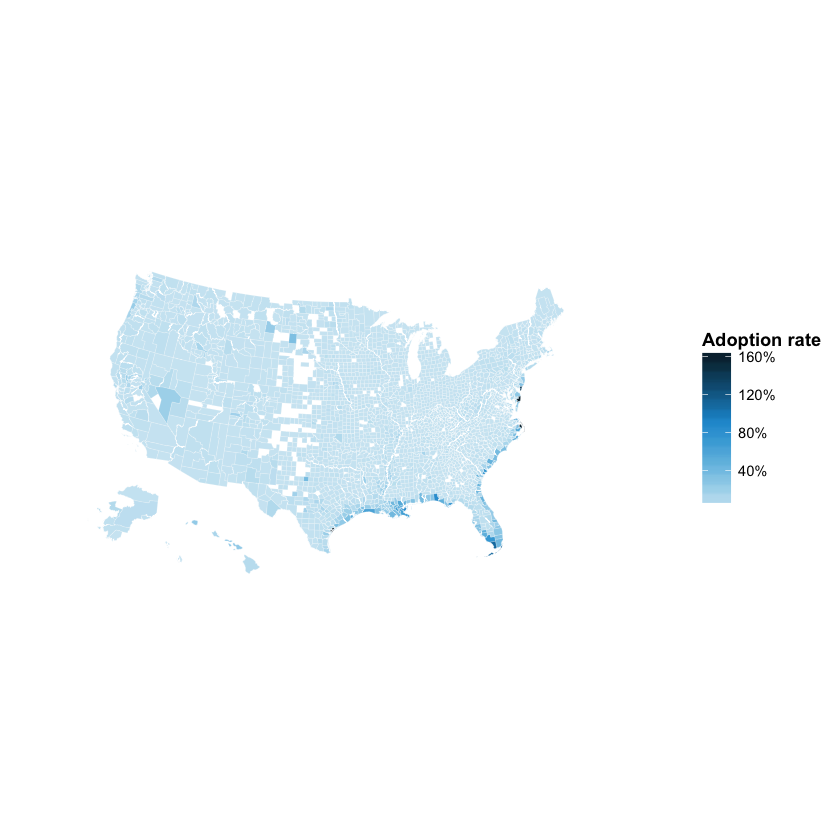

In [22]:
figAdopt

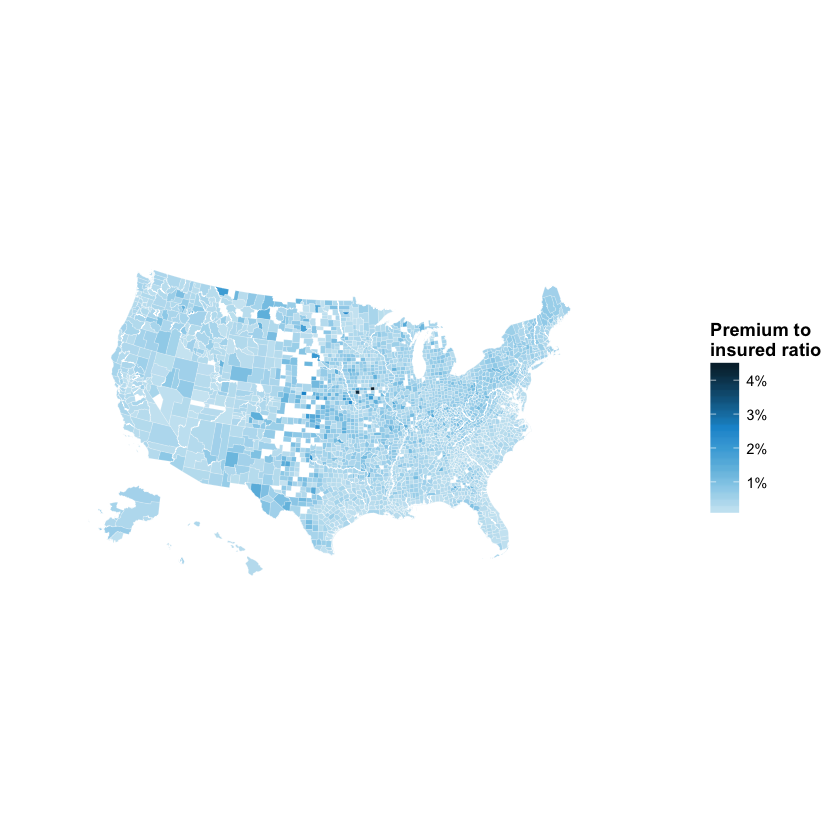

In [23]:
figImpRate

Unlike the coverage or adoption map, the map of effective prices is a bit surprising. There appears to be more variation within states and regions than seen for adoption rates.

## Outline 
There are three steps. 1: Reading in the information from Fema's website and saving it as a dataframe, 2: Mapping it using the Urban Institute's urbnmapr packge and, finally 3: estimating the price elasticity of insurance adoption using regression analysis and random forests. The statistical analysis is presented first, as that is of main interest. Naturally, those wishing to reproduce the analysis should follow the above outline when running the relevant sections of R scripts.

## Estimation methods
We estimate the elasticity using three methods: linear regression, random forests and a model that has the form of a logistic regression, but is estimated using ordinary least squares rather than maximum likelihood.

See the data download and preparation section for details on how the following dataset was created. 

In [1]:
load("femaRegData.rdata")

## Linear Regression
As we are interested in estimating elasticities the variables enter in logarithmic form. The response or Y variable is the adoption rate '_adopt_', while the key explanatory variable is the calculated (implicit) price '_imprate_'. Other variables entering the regression are the median household income '_medhhincome_' in the county, the home ownership rate '_horate_' and the location variables latitude and longitude which appear in quadratic form. 

In [30]:
#model with "implicit" actuarial rate i.e. for the county 
model1 <- lm(log(adopt)~ log(imprate) + log(medhhincome) + log(horate) + long + I(long^2) + lat + I(lat^2), data=join1)
summary(model1) 



Call:
lm(formula = log(adopt) ~ log(imprate) + log(medhhincome) + log(horate) + 
    long + I(long^2) + lat + I(lat^2), data = join1)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.4962 -0.7873 -0.0319  0.7320  4.7374 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      25.2392570  2.3077843  10.937  < 2e-16 ***
log(imprate)      0.2034595  0.0470101   4.328 1.56e-05 ***
log(medhhincome)  0.8161897  0.1139327   7.164 9.91e-13 ***
log(horate)      -0.4865677  0.2432598  -2.000   0.0456 *  
long              0.4022793  0.0264181  15.227  < 2e-16 ***
I(long^2)         0.0020450  0.0001373  14.895  < 2e-16 ***
lat              -0.8799543  0.0639851 -13.752  < 2e-16 ***
I(lat^2)          0.0102797  0.0008371  12.280  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.228 on 2895 degrees of freedom
Multiple R-squared:  0.1913,	Adjusted R-squared:  0.1894 
F-statistic: 97.86 on 7 and 2895

The estimated elasticity is 0.2034, which is a bit embarassing! We should really have a negative number! Adoption (like demand) must fall with prices. One concern with demand estimation is that prices are often correlated with variables that are part in the estimation. The usual way out of the issue is to use instruments for cost shifters (which affect the supply of insurance alone) and help estimate or identify the demand curve.

Lacking instruments, we take a different approach here and restimate our model on a subset of the sample. We restrict attention to only those observations where the implied prices is at least as high as the median. This does not get rid of the endogeneity problem above and our estimate may very likely be biased.

In [34]:
summary(join1$imprate)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.001066 0.003145 0.004480 0.005105 0.006329 0.044600 

In [45]:
idx <- which(join1$imprate > .00448) #use median 
joinMod <- join1[idx,]

model2 <- lm(log(adopt)~ log(imprate) + log(medhhincome) + log(horate) + long + I(long^2) + lat + I(lat^2), data=joinMod)
summary(model2) 


Call:
lm(formula = log(adopt) ~ log(imprate) + log(medhhincome) + log(horate) + 
    long + I(long^2) + lat + I(lat^2), data = joinMod)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.9116 -0.6578  0.0271  0.6815  3.8233 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      14.8403956  3.0690304   4.836 1.47e-06 ***
log(imprate)     -0.4064961  0.0894576  -4.544 5.98e-06 ***
log(medhhincome)  0.2883038  0.1559227   1.849 0.064660 .  
log(horate)       0.2291207  0.3740217   0.613 0.540246    
long              0.3624731  0.0353121  10.265  < 2e-16 ***
I(long^2)         0.0018707  0.0001876   9.969  < 2e-16 ***
lat              -0.3450669  0.0911966  -3.784 0.000161 ***
I(lat^2)          0.0039535  0.0011799   3.351 0.000826 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.041 on 1443 degrees of freedom
Multiple R-squared:  0.1187,	Adjusted R-squared:  0.1145 
F-statistic: 27.78 on 7 and 14

Now the estimate has the correct sign and the sign on home ownership rate is also correct. 

A price elasticity of -0.406 for insurance adoption suggests that a 10 percent increase in flood insurance pricing could lower adoption rates by 4.06 percent. This estimate is also in the same ballpark as some of those mentioned in a [report](https://www.nap.edu/read/21709/chapter/6#52) on the affrodability of flood insurance prepared by the National Academies of Science, Engineering and Medicine.

As a sanity check, we redo the elasticity calculation for the prices that are (at least) at the 25th and 75th percentiles. 

In [36]:
idx <- which(join1$imprate > .003) #use median 
joinMod <- join1[idx,]

model2 <- lm(log(adopt)~ log(imprate) + log(medhhincome) + log(horate) + long + I(long^2) + lat + I(lat^2), data=joinMod)
model2$coef[2]

log(imprate) 
  -0.1480678

Thus, when we include all counties where the implicit price is at least 0.3 percent (rate is lowest 25%), then the estimated elasticity is -0.14. When we only include counties in which the rate is in the top quartile, then we obtain:  

In [37]:
idx <- which(join1$imprate > .006) #use median 
joinMod <- join1[idx,]

model2 <- lm(log(adopt)~ log(imprate) + log(medhhincome) + log(horate) + long + I(long^2) + lat + I(lat^2), data=joinMod)
model2$coef[2]

log(imprate) 
  -0.7854043

an elasticity of -.78. Thus, for counties where the insurance rate is already quite high, a further 10 percent increase in rates could lower insurance purchases by almost 8 percent. 

Staying with the results for the median level of rates, let us look at the location effects from the latitude and longitude.

In [39]:
-model2$coef[5]/(2*model2$coef[6]) #equating the partial effect (derivative) of longitude to be zero

long 
-96.88146

Thus the effect of longitude is zero around -96 degrees, say around central Texas. As we move east however, say in between Louisiana and Florida, the effect of a one degree increase on flood insurance adoption is given by  

In [42]:
model2$coef[5]+2*model2$coef[6]*(-85) #-90 degrees, New Orleans
model2$coef[5]+2*model2$coef[6]*(-75) #-80 degrees (Florida gulf coast)

long 
0.04445341

long 
0.08186749

Thus, as *we move east* towards the atlantic coast, insurance adoption gets stronger; about 4.44 percent more (for *each additional degree* of longitude) at New Orleans and almost 8 percent higher for each additional degree at Florida's gulf coast.

Moving on, the model also estimates the impact of moving north on flood insurance adoption levels as follows

In [43]:
model2$coef[7]+2*model2$coef[8]*(30) #latitude around gulf cost 
model2$coef[7]+2*model2$coef[8]*(40) #around the US Canada border

lat 
-0.1078553

lat 
-0.02878476

These estimates suggest each additional degree of latitude is associated with a decrease of 10.8 percent in insurance coverage (starting from the gulf coast). This slows down to about 2.8 percent as we approach the Canadian border.

## Random Forest based estimation
I use the R package 'grf.' This package is designed to estimate heterogenous (potentially causal) treatment effects (for binary treatments). However, I use it to estimate partial effect of a continuous variable by combining it with the anatomy of regression formula.

In [46]:
library(grf)
grf.Y <- log(joinMod$adopt) #response variable
grf.X <- log(joinMod$imprate) #explanatory variable of main interest

#other covariates
grf.Rest <- cbind(log(joinMod$medhhincome),log(joinMod$horate),joinMod$lat,joinMod$long)

#fit two regression forests
rF.Y <- regression_forest(grf.Rest,grf.Y,sample.fraction=.5, num.trees=200)
rF.X <- regression_forest(grf.Rest,grf.X,sample.fraction=.5, num.trees=200)

#obtain fitted values
pred.Y <- predict(rF.Y)
pred.X <- predict(rF.X)

#get the residuals
resid.Y <- grf.Y - pred.Y$predictions
resid.X <- grf.X - pred.X$predictions

#now use a simple linear regression to obtain an estimate for the elasticity 
#as an appeal to the multivariate regression anatomy formula cov(resid.Y,resid.X)/var(resid.X)
summary(lm(resid.Y~resid.X))


Call:
lm(formula = resid.Y ~ resid.X)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6073 -0.5632  0.0251  0.5902  4.6239 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.005447   0.025479  -0.214    0.831    
resid.X     -0.452178   0.086781  -5.211 2.15e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9705 on 1449 degrees of freedom
Multiple R-squared:  0.01839,	Adjusted R-squared:  0.01772 
F-statistic: 27.15 on 1 and 1449 DF,  p-value: 2.154e-07


The estimate for the elasticity is quite similar -.45 (vs -.40 for linear regression). **Note** As above, this only uses the rows (counties) where the implied price or rate is at least as high as the median. As this is a stochastic algorithm, there will be some differences in estimates obtained in each run. However, they should not be too far off.
### Advantage of blended approach
The regression model used in the analysis is quite simple with just some logarithmic terms and a couple of quadratics. As models become more complex, however, then one has to worry about introducing _too much structure_ (and therefore bias). The benefit of the blended appraoch is that the regression of response ('Y') and key explanatory variables ('X' can be left to random forests, which can outperform linear regression. 

One can imagine the random forest as providing a better approximation to the underlying statistical relationships between Y (or X) and the covariates other than those in X. However, once we have the residuals, we can simply use linear regression for the last step and also obtain confidence intervals in the usual way. 

## Logistic regression version
Our final estimation method uses a logistic formulation where we interpret the adoption rates as choice probabililties (assuming all households in a county use the same choice probability)." Using 's' to denote the adoption rate, the logisitic version of a generalized linear model we have 

s = exp(X.Beta)/[1+exp(X.Beta)]

or, inverting the system, we can estimate the model using ordinary least squares as 

y = log[s/(1-s)] = X.Beta 
of course, we have to make sure that s lies between 0 and 1 (so we drop the problematic 5 counties where s>1). As above, we estimate the elasticity using only those counties where the implicit rate is at least as high as the median.

In [2]:
s <- join1$adopt
badCty <- which((s==0)|(s>1)) #counties in which probability interpretation does not work because share exceed 1 or is 0.#turns out same 5 with s>1, none with s=0.
idx <- which(join1$imprate < .00448) #median 

#use any one  
dataModLog <- join1[-c(badCty,idx),]  #all counties with imprate>median of .0448

Estimate the "linearized" model

In [6]:
modelNomLog <- lm(I(log(adopt/(1-adopt))) ~ log(imprate) + log(medhhincome) + log(horate) + long + I(long^2) + lat + I(lat^2), data = dataModLog)  #nominally logistic but estimated via OLS
summary(modelNomLog)


Call:
lm(formula = I(log(adopt/(1 - adopt))) ~ log(imprate) + log(medhhincome) + 
    log(horate) + long + I(long^2) + lat + I(lat^2), data = dataModLog)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.9362 -0.6703  0.0194  0.6781  4.9716 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      15.0020251  3.1344137   4.786 1.87e-06 ***
log(imprate)     -0.4153091  0.0912136  -4.553 5.73e-06 ***
log(medhhincome)  0.2462025  0.1595461   1.543  0.12302    
log(horate)       0.3188052  0.3821900   0.834  0.40433    
long              0.3695794  0.0360037  10.265  < 2e-16 ***
I(long^2)         0.0019112  0.0001913   9.989  < 2e-16 ***
lat              -0.3142634  0.0943709  -3.330  0.00089 ***
I(lat^2)          0.0035625  0.0012194   2.922  0.00354 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.061 on 1442 degrees of freedom
Multiple R-squared:  0.1142,	Adjusted R-squared:  0.1099 
F-statistic:

The coefficients are very similar to those for the linear regression method above. However, these coefficients do not provide an exact estimate for the elasticity of insurance adoption (s), rather they provide the elasticity for the *odds ratio* s/(1-s).

To obtain the elasticity, we use the fitted values i.e the model's predictions (which we will convert to logarithmic form to obtain elasticity interpretations.

In [5]:
predLog <- predict(modelNomLog) 
predExp <- exp(predLog)/(1+exp(predLog))
summary(lm(log(predExp)~log(dataModLog$imprate)))


Call:
lm(formula = log(predExp) ~ log(dataModLog$imprate))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.50584 -0.22878 -0.06364  0.16127  1.81638 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -7.97979    0.13181  -60.54   <2e-16 ***
log(dataModLog$imprate) -0.64329    0.02631  -24.45   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3164 on 1448 degrees of freedom
Multiple R-squared:  0.2923,	Adjusted R-squared:  0.2918 
F-statistic:   598 on 1 and 1448 DF,  p-value: < 2.2e-16


Thus, the elasticity is estimated to be around -0.64 compared to -0.4 for the linear regression estimate. The difference is to be anticipated as changing the response variable from log(s) to log(s/(1-s) has changed the range from [-\infty,0] to [-\infty, +\infty]. We do not repeat the exercise with a random forest, but we expect it to provide a similar estimate for the logsitic formulation.

## Data download and preparation
Read in the data set created from downloaded Fema page to avoid making multiple requests.

In [ ]:
download.file("https://bsa.nfipstat.fema.gov/reports/1011.htm","femaState.html") #download to local file

Note: Example of data entry errors. For Florida, "Monroe County" is also listed as just "Monroe".

In [24]:
#Run these functions once for removing commas from numbers or excess whitespace
remComma <-function(x){
	x<-gsub(",","",x)
}

trimWS <- function(x) {
  gsub("(^[[:space:]]+|[[:space:]]+$)", "", x)
}

read in the information (fixed width format).

In [ ]:
# read State data from file using the fixed width format
femaDataState <- read.fwf(
			file = "femaState.html", #url("https://bsa.nfipstat.fema.gov/reports/1011.htm")
			skip = 16,
			widths = c(17,39-17,54-39,69-54,87-69),
			n = 55,
			comment.char="",
			#quote ="'\""
)

Remove the HTML tags, strip whitespace, remove commmas from numbers, convert numbers from character to real.

In [ ]:
femaDataState$V1 <- gsub("<A HREF=\"#*","",femaDataState$V1)
femaDataState$V1 <- gsub("\">","",femaDataState$V1)
femaDataState$V2 <- gsub("<.*?>","",femaDataState$V2)
femaDataState[,1:2]<-apply(femaDataState[,1:2],MARGIN=2,FUN=trimWS)
femaDataState[,3:5]<-apply(femaDataState[,3:5],MARGIN=2,FUN=remComma)
femaDataState[,3:5]<-apply(femaDataState[,3:5],MARGIN=2,FUN=as.numeric)
colnames(femaDataState)<-c("Tag", "State","Num.Policies", "Insured.Value", "Premiums.Written")

save to local Rdata file.

In [ ]:
save(femaDataState,file="femaDataState.rdata") #used to create county level data files (separately for each state)

Read in county information state by state

In [ ]:
## Reading County level Data from saved rdata file 
x<- readLines("femaState.html",n=-1) 
load("femaDataState.rdata")
stateList = femaDataState$State 
for (i in 1: length(stateList )) {	
	stateName <- stateList[i]   #change for other states
	locStateName<-grep(stateName,x)
	x[locStateName] # print to see which one to set as start and stop. #e.g. Virigina should be 3rd occurence, because West Virginia messes up the counts 

	locSt<-which(trimWS(x[locStateName]) == stateName) #where state data starts in grep results
	locStEnd <- grep("Total for",x[locStateName]) #where it ends in grep results
		
	stateStart<- locStateName[min(locSt)]-5 #where start data starts in html file
	stateEnd<- locStateName[locStEnd] #where it ends	 in html file	
	
	femaDataCounty <- read.fwf(
				file = "femaState.html", #url("https://bsa.nfipstat.fema.gov/reports/1011.htm")
				skip = stateStart-1,
				widths = c(34,68-34,83-68,101-83,117-101),
				n = (stateEnd-2)-(stateStart-1),
				comment.char="",
				quote ="'\"",
	)


more reading, cleanup

In [ ]:
remLines <- grep("Policy Statistics", x)
	toRem<-remLines[which((remLines < stateEnd)&(remLines > stateStart))] #lines within state with "policy statistics"
	toRem <- toRem-(stateStart-1)
	delIndx<-c(toRem-4,toRem-3,toRem-2,toRem-1,toRem,toRem+1,toRem+2,toRem+3,toRem+4,toRem+5,toRem+6)
	#x[delIndx+stateStart-1]
	femaDataCounty <-femaDataCounty[-(delIndx),] #strip away text info
		
	femaDataCounty[,3:5]<-apply(femaDataCounty[,3:5],MARGIN=2,FUN=remComma)
	femaDataCounty[,3:5]<-apply(femaDataCounty[,3:5],MARGIN=2,FUN=as.numeric)
	femaDataCounty[,1:2]<-apply(femaDataCounty[,1:2],MARGIN=2,FUN=trimWS)
	
	numRows = dim(femaDataCounty)[1]
	femaDataCounty[,6] = rep(stateName,numRows)
	rownames(femaDataCounty)<-as.character(1:numRows)
	colnames(femaDataCounty)<-c("County", "Community", "Num.Policies", "Insured.Value", "Premiums.Written", "State")
	#take a peek
	print(head(femaDataCounty))
	
	save(femaDataCounty,file=paste(stateName,".rdata", sep=""))
	print(paste("Data saved as ", stateName,".rdata", sep=""))

Finally, aggregate the county level (cities) information and save as individual files

In [ ]:
#Aggregate County Values 
	nonEmptyCty <- which(femaDataCounty[,1] != "") #rows with county names (not blank) 	
	nonEmpCtyNames <- femaDataCounty[nonEmptyCty,1] #county names
	lenNonEmp <- length(nonEmpCtyNames) #no. of named counties
	
	if(lenNonEmp<1){ #if no named counties, e.g. N. Mariana Islands. Alternative, mark as N.A?
		femaDataCounty[,1]<-rep("Not Avail.",times=dim(femaDataCounty)[1])
		#next #or skip writing the county level file  
	} 
	
	##[BUG/warning: assumes county name repeat due to page spillover happens once at most]
	rptCty <- which(nonEmpCtyNames[1:lenNonEmp-1]==nonEmpCtyNames[2:lenNonEmp]) #list of rows with repeated county name (page spillover)
	rptCty <- rptCty+1 #find repeat occurrences to remove
	#femaDataCounty[nonEmptyCty[rptCty],1] #print with rptCty and rptCty-1 to confirm
	femaDataCounty[nonEmptyCty[rptCty],1]<-"" #make repeat mentions blank 
	#rinse repeat to now identify first occurrence
	newNonEmptyCty <- which(femaDataCounty[,1] != "") #rows without blank counties
	
	#sum up values for each county
	femaCtyAgg <-femaDataCounty[newNonEmptyCty,-2]
		
	if(length(newNonEmptyCty)>1)	{
		#for all counties except the last one
		for (j in 1:(length(newNonEmptyCty)-1)){
			rowstart <- newNonEmptyCty[j]
			rowend <- newNonEmptyCty[j+1]-1
			femaCtyAgg[j,2:4] <- apply(femaDataCounty[rowstart:rowend,3:5],MARGIN=2,sum)
		}	
		#for the last one
		femaCtyAgg[j+1,2:4] <- apply(femaDataCounty[newNonEmptyCty[j+1]:dim(femaDataCounty)[1],3:5],MARGIN=2,sum)		
	}else{		#if there is just one county e.g. D.C.
		femaCtyAgg[1,2:4] <- apply(femaDataCounty[newNonEmptyCty[1]:dim(femaDataCounty)[1],3:5],MARGIN=2,sum)
	}
	
	#change the row names
	numRows = dim(femaCtyAgg)[1]
	rownames(femaCtyAgg)<-as.character(1:numRows)
	
	#save the data
	save(femaCtyAgg,file=paste(stateName,"Cty.rdata", sep=""))
	print(paste("Data saved as ", stateName,"Cty.rdata", sep=""))
}

### Mapping the data
I use R package urbnmapr from the Urban Institute's github repository

In [2]:
library(tidyverse)
library(urbnmapr)  #the Urban Institute's mapping package with shapefiles.

## some theme elements from urban map
urban_map <- theme(
  panel.background = element_blank(),
  axis.text = element_blank(),
  axis.ticks = element_blank(),
  axis.title = element_blank(),
  panel.grid = element_blank(),
  axis.line = element_blank() 
)

scale_colour_gradientn <- function(..., 
                                   colours = c("#CFE8F3","#A2D4EC","#73BFE2","#46ABDB", "#1696D2","#12719E","#0A4C6A","#062635"), 
                                   colors = c("#CFE8F3","#A2D4EC","#73BFE2","#46ABDB", "#1696D2","#12719E","#0A4C6A","#062635"),
                                   values = NULL, 
                                   space = "Lab", 
                                   na.value = "grey50", 
                                   guide = "colourbar") {
  
  colours <- if (missing(colours)) colors else colours
  
  continuous_scale("colour", "gradientn",
                   scales::gradient_n_pal(colours, values, space), na.value = na.value, guide = guide, ...)
}

scale_color_gradientn <- scale_colour_gradientn

scale_fill_gradientn <- function(..., 
                                 colours = c("#CFE8F3","#A2D4EC","#73BFE2","#46ABDB", "#1696D2","#12719E","#0A4C6A","#062635"), 
                                 colors = c("#CFE8F3","#A2D4EC","#73BFE2","#46ABDB", "#1696D2","#12719E","#0A4C6A","#062635"),
                                 values = NULL, 
                                 space = "Lab", 
                                 na.value = "grey50", 
                                 guide = "colourbar") {
  
  colours <- if (missing(colours)) colors else colours
  
  continuous_scale("fill", "gradientn",
                   scales::gradient_n_pal(colours, values, space), na.value = na.value, guide = guide, ...)
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.5
✔ tidyr   0.8.1     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


For convenience, merge county data and shapefile data (from urbnmapr package)

In [3]:
#library(urbnmapr)
ctyFips <- unique(counties$county_fips)
numCty <- length(ctyFips)

rowMin <- rep(0,times=numCty)
for (i in 1:numCty){
	rowMin[i] <- min(which(counties$county_fips ==ctyFips[i]))
}

countyDataMod <- countydata
countyDataMod$county_name <- counties$county_name[rowMin]
countyDataMod$state_name <- counties$state_name[rowMin]

head(countyDataMod)
tail(countyDataMod)

save(countyDataMod,file="myCtyDataMod.rdata")


year,county_fips,hhpop,horate,medhhincome,county_name,state_name
2015,01001,20237.133,0.7460823,52200,Autauga County,Alabama
2015,01003,72269.000,0.7325963,53600,Baldwin County,Alabama
2015,01005,10286.984,0.5873022,32400,Barbour County,Alabama
2015,01007,8197.529,0.6866584,26000,Bibb County,Alabama
2015,01009,21093.589,0.8319409,53000,Blount County,Alabama
2015,01011,4103.850,0.5873022,32400,Bullock County,Alabama


year,county_fips,hhpop,horate,medhhincome,county_name,state_name
2015,56035,3985.055,0.7483310,65000,Sublette County,Wyoming
2015,56037,17112.295,0.7483310,65000,Sweetwater County,Wyoming
2015,56039,8580.292,0.7021267,62000,Teton County,Wyoming
2015,56041,8251.408,0.7483310,65000,Uinta County,Wyoming
2015,56043,3367.812,0.7285312,67000,Washakie County,Wyoming
2015,56045,2846.603,0.7285312,67000,Weston County,Wyoming


The saved Rdata files can now be read in to merge information and create the maps

In [5]:
load("femaDataState.rdata")
statesToMap <-femaDataState$State #read in information for all states and terr.

rm(femaCtyAgg) #clear current if present
load(paste(statesToMap[1],"Cty.rdata",sep="")) #load the first
merged <- femaCtyAgg

for(i in 2:length(statesToMap)){
	dim(merged)
	rm(femaCtyAgg) #clear current 
	load(paste(statesToMap[i],"Cty.rdata",sep=""))
	merged<- rbind(merged,femaCtyAgg)
}
rownames(merged) <- c(as.character(1:dim(merged)[1]))

remove rows with missing policy information

In [6]:
missInfo <- which(is.na(merged[,2])==T)
merged<-merged[-missInfo,]

average value insured and premium

In [7]:
apply(cbind(merged[,3]/merged[,2],merged[,4]/merged[,2]),MARGIN=2,FUN=mean)

[1] 200345.5878    895.3047

So the typical household paid an premium of about \$895 for coverage (building + contents) of \$200K.

In [8]:
apply(cbind(merged[,3]/merged[,2],merged[,4]/merged[,2]),MARGIN=2,FUN=median)

[1] 200657.4468    838.4645

the median is not all that different. County names zre not unique across states. For better matching, combine the county and state names, store it in a variable combo".

In [9]:
merged$combo <- tolower(paste(merged$County,merged$State,sep=" "))

load("myCtyDataMod.rdata") #loads as countyDataMod
countyDataMod$combo <- tolower(paste(countyDataMod$county_name,countyDataMod$state_name,sep=" "))

then join the FEMA data with county data

In [10]:
join1 <- left_join(merged,countyDataMod, by = "combo")
head(join1)

County,Num.Policies,Insured.Value,Premiums.Written,State,combo,year,county_fips,hhpop,horate,medhhincome,county_name,state_name
ANCHORAGE BOROUGH,424,120517000,323159,Alaska,anchorage borough alaska,NA,NA,NA,NA,NA,NA,NA
ANIAK,6,2964900,6400,Alaska,aniak alaska,NA,NA,NA,NA,NA,NA,NA
BETHEL CENSUS AREA,119,32230300,210734,Alaska,bethel census area alaska,2015,02050,5001.385,0.5994979,61900,Bethel Census Area,Alaska
BRISTOL BAY,1,178800,3422,Alaska,bristol bay alaska,NA,NA,NA,NA,NA,NA,NA
BRISTOL BAY DIVISION,1,250000,892,Alaska,bristol bay division alaska,NA,NA,NA,NA,NA,NA,NA
DILLINGHAM CENSUS AREA,2,850000,1704,Alaska,dillingham census area alaska,2015,02070,1419.748,0.5994979,61900,Dillingham Census Area,Alaska


Create a variable to keep track of policy adoption rates across counties

In [11]:
join1$adopt <- join1$Num.Policies/join1$hhpop

In [12]:
summary(join1$adopt)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.00009 0.00401 0.00880 0.02969 0.01925 1.63254      64 

The average (for the nation) looks okay at about 3%, but the max value is very strange as the number of policies should not be higher than the number of households or population. Need to check what hhpop is measuring, or use a different data source.

Continuing for now, merge the data with shapefile data

In [14]:
length(which(join1$adopt>1))
length(join1$adopt)

[1] 5

[1] 2967

Thus, only 5 out of nearly 5000 observations have potential errors. And seen below, the highest adoption rate otherwise is around 86 percent. 

In [18]:
max(join1$adopt[-(which(join1$adopt>1))], na.rm=T)

[1] 0.8598782

In [19]:
mapLoss <- counties
mapLoss$county_name <- tolower(mapLoss$county_name)
mapLoss$state_name <- tolower(mapLoss$state_name)

data_merged <- left_join(join1,mapLoss, by = "county_fips")
rm(mapLoss)
head(data_merged)


County,Num.Policies,Insured.Value,Premiums.Written,State,combo,year,county_fips,hhpop,horate,⋯,lat,order,hole,piece,group,state_abbv,state_fips,county_name.y,fips_class,state_name.y
ANCHORAGE BOROUGH,424,120517000,323159,Alaska,anchorage borough alaska,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ANIAK,6,2964900,6400,Alaska,aniak alaska,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
BETHEL CENSUS AREA,119,32230300,210734,Alaska,bethel census area alaska,2015,02050,5001.385,0.5994979,⋯,25.24206,6781,FALSE,1,02050.1,AK,02,bethel census area,H5,alaska
BETHEL CENSUS AREA,119,32230300,210734,Alaska,bethel census area alaska,2015,02050,5001.385,0.5994979,⋯,25.24451,6782,FALSE,1,02050.1,AK,02,bethel census area,H5,alaska
BETHEL CENSUS AREA,119,32230300,210734,Alaska,bethel census area alaska,2015,02050,5001.385,0.5994979,⋯,25.25247,6783,FALSE,1,02050.1,AK,02,bethel census area,H5,alaska
BETHEL CENSUS AREA,119,32230300,210734,Alaska,bethel census area alaska,2015,02050,5001.385,0.5994979,⋯,25.25354,6784,FALSE,1,02050.1,AK,02,bethel census area,H5,alaska


In [15]:
names(data_merged)

[1] "County"           "Num.Policies"     "Insured.Value"    "Premiums.Written"
 [5] "State"            "combo"            "year"             "county_fips"     
 [9] "hhpop"            "horate"           "medhhincome"      "county_name.x"   
[13] "state_name.x"     "adopt"            "long"             "lat"             
[17] "order"            "hole"             "piece"            "group"           
[21] "state_abbv"       "state_fips"       "county_name.y"    "fips_class"      
[25] "state_name.y"

some column names appear in both files, so distinguished by ".x" or ".y" endings. Now to map the information.

First map the adoption rates at the county level.

In [20]:
figAdopt<-data_merged %>%
  filter(state_name.y %in%  tolower(statesToMap)) %>%
  ggplot(aes(long, lat, group = group, fill = (adopt) )) +
    geom_polygon(color = "#ffffff", size = 0.05) +
    coord_map(projection = "albers", lat0 = 39, lat1 = 45) +
    scale_fill_gradientn(labels = scales::percent) +  #::percent or ::dollar
    urban_map +
    theme(legend.position = "right",#"right",
          legend.direction = "vertical",#"vertical",
          legend.title = element_text(face = "bold", size = 11),
          legend.key.height = unit(.25, "in")) +
  labs(fill = "Adoption rate")


Then, plot a map to represent the relative prices (aggregated at the county level). 


In [21]:
figImpRate<-data_merged %>%
  filter(state_name.y %in%  tolower(statesToMap)) %>%
  ggplot(aes(long, lat, group = group, fill = (Premiums.Written/Insured.Value) )) +
    geom_polygon(color = "#ffffff", size = 0.05) +
    coord_map(projection = "albers", lat0 = 39, lat1 = 45) +
    scale_fill_gradientn(labels = scales::percent) +  #::percent or ::dollar
    urban_map +
    theme(legend.position = "right",#"right",
          legend.direction = "vertical",#"vertical",
          legend.title = element_text(face = "bold", size = 11),
          legend.key.height = unit(.25, "in")) +
  labs(fill = "Premium to \ninsured ratio")


## Estimation of elasticity
First we create new data frames to make it easier to use with regression analysis (and future use).

In [27]:
library(urbnmapr)
ctyFips <- unique(counties$county_fips)
numCty <- length(ctyFips)

rowMin <- rep(0,times=numCty)
for (i in 1:numCty){
	rowMin[i] <- min(which(counties$county_fips ==ctyFips[i]))
}

head(counties[rowMin,])

countyDataMod <- countydata #copy original from package

countyDataMod$county_name <- counties$county_name[rowMin]
countyDataMod$state_name <- counties$state_name[rowMin]
countyDataMod$long <- counties$long[rowMin]
countyDataMod$lat <- counties$lat[rowMin]

countyDataMod$gulf <- countyDataMod$atl <- rep(0, times=numCty)
 
save(countyDataMod, file= "myCtyDataMod.rdata")

long,lat,order,hole,piece,group,county_fips,state_abbv,state_fips,county_name,fips_class,state_name
-86.91760,32.66417,1,FALSE,1,01001.1,01001,AL,01,Autauga County,H1,Alabama
-88.02927,30.22271,52,FALSE,1,01003.1,01003,AL,01,Baldwin County,H1,Alabama
-85.74142,31.61961,379,FALSE,1,01005.1,01005,AL,01,Barbour County,H1,Alabama
-87.42194,33.00338,432,FALSE,1,01007.1,01007,AL,01,Bibb County,H1,Alabama
-86.96211,33.86769,463,FALSE,1,01009.1,01009,AL,01,Blount County,H1,Alabama
-85.99916,32.25054,539,FALSE,1,01011.1,01011,AL,01,Bullock County,H1,Alabama


These sections are like small source files which can be run separately.

In [28]:
load("myCtyDataMod.rdata") #loads as countyDataMod
#head(countyDataMod)

load("femaDataState.rdata")
statesToMap <-femaDataState$State #[c(2,11,12,21,28,47)]
 
rm(femaCtyAgg) #clear current 
load(paste(statesToMap[1],"Cty.rdata",sep="")) #load the first
merged <- femaCtyAgg
 
	for(i in 2:length(statesToMap)){
	 	dim(merged)
	 	rm(femaCtyAgg) #clear current 
	 	load(paste(statesToMap[i],"Cty.rdata",sep=""))
	 	merged<- rbind(merged,femaCtyAgg)
	 }
rownames(merged) <- c(as.character(1:dim(merged)[1]))
 
#missing policy numbers
missInfo <- which(is.na(merged[,2])==T)
merged<-merged[-missInfo,]

#head(merged)
countyDataMod$combo <- tolower(paste(countyDataMod$county_name,countyDataMod$state_name,sep=" "))
merged$combo <- tolower(paste(merged$County,merged$State,sep=" "))

#requires tidyverse 
join1 <- left_join(merged,countyDataMod, by = "combo")
 
rowNA <- which(is.na(join1$hhpop)==T)
join1<-join1[-rowNA,]
join1$adopt <- join1$Num.Policies/join1$hhpop #adoption rate
join1$avgPrem <-join1$Premiums.Written/join1$Num.Policies #average premium
join1$imprate <- join1$Premiums.Written/join1$Insured.Value #implicit premium or rate

save(join1,file="femaRegData.rdata")


In [29]:
names(join1)

[1] "County"           "Num.Policies"     "Insured.Value"    "Premiums.Written"
 [5] "State"            "combo"            "year"             "county_fips"     
 [9] "hhpop"            "horate"           "medhhincome"      "county_name"     
[13] "state_name"       "long"             "lat"              "atl"             
[17] "gulf"             "adopt"            "avgPrem"          "imprate"